In [406]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB


from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix ,classification_report, accuracy_score
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score

from sklearn.impute import SimpleImputer


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree


import pandas_profiling

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

import plotly.plotly as py
import plotly.figure_factory as ff
import plotly
import plotly.graph_objs as go
import plotly.tools as tls


In [151]:
df_churn = pd.read_csv('Telco-Customer-Churn.csv')

In [152]:
df_churn

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


### Dropping "CustomerID" as it provides no signal

In [70]:
df_churn.drop(['customerID'], axis=1, inplace=True)

### Replacing empty spaces with null values in "TotalCharges"

In [71]:
df_churn['TotalCharges'] = df_churn["TotalCharges"].replace(" " , np.nan)

### Dropping nulls from "TotalCharges" 

In [72]:
df_churn = df_churn[df_churn["TotalCharges"].notnull()]
df_churn = df_churn.reset_index()[df_churn.columns]

### Converting strings to floats in "TotalCharges"

In [73]:
df_churn["TotalCharges"] = df_churn["TotalCharges"].astype(float)

### replacing 'No internet service' to 'No' for columns which show 'No internet service'

Making it more consistent, logically sound

In [74]:
replace_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies']

for i in replace_columns : 
    df_churn[i]  = df_churn[i].replace({'No internet service' : 'No'})

In [75]:
'''

''';
    
# #replace values
# df_churn["SeniorCitizen"] = df_churn["SeniorCitizen"].replace({1:"Yes",0:"No"})


### Function to bin tenures

I might come back to this and rebin later. Especially curious about more bins to differntiate users with less than 2 years further.

In [76]:
def bin_tenure(df_churn):
    
    if df_churn["tenure"] <= 12 :
        return "Tenure_0_to_12"
    elif (df_churn["tenure"] > 12) & (df_churn["tenure"] <= 24 ):
        return "Tenure_12_to_24"
    elif (df_churn["tenure"] > 24) & (df_churn["tenure"] <= 48) :
        return "Tenure_24_to_48"
    elif (df_churn["tenure"] > 48) & (df_churn["tenure"] <= 60) :
        return "Tenure_48_to_60"
    elif df_churn["tenure"] > 60 :
        return "Tenure_60+"

### binning tenure 

In [77]:
df_churn["tenure_bin"] = df_churn.apply(lambda df_churn:bin_tenure(df_churn), axis = 1)

In [78]:
# cat_cols   = df_churn.nunique()[df_churn.nunique() <= 5].keys().tolist()
# cat_cols;

In [79]:
# Separating churn and non-churn
df_only_churn     = df_churn[df_churn["Churn"] == "Yes"]
df_not_churn = df_churn[df_churn["Churn"] == "No"]

# Separating columns by numerical and categorical, target column is "Churn"
target_col = ["Churn"]

cat_cols   = df_churn.nunique()
cat_cols   = df_churn.nunique()[df_churn.nunique() <= 5].keys().tolist()
cat_cols   = [col for col in cat_cols if col not in target_col]
num_cols   = [col for col in df_churn.columns if col not in cat_cols + target_col]


# get binary columns with 2 values
bin_cols   = df_churn.nunique()[df_churn.nunique() == 2].keys().tolist()
# get columns with more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

In [82]:
# df_churn

### Standardizing
Standardizing the columns with numerical data, i.e. 'tenure', 'MonthlyCharges', 'TotalCharges'

In [110]:
std = StandardScaler()
df_scaled = std.fit_transform(df_churn[num_cols])
df_scaled = pd.DataFrame(scaled,columns=num_cols)

In [111]:
df_scaled;

backup df as pickle

In [128]:

# df_scaled.to_pickle("./df_churn.pkl")


### Merging the standardized columns into original df, dropping old values

In [120]:
df_churn_scaled = df_churn.drop(columns = num_cols,axis = 1)
df_churn_scaled = df_churn_scaled.merge(df_scaled,left_index=True,right_index=True,how = "left")

In [130]:
df_churn_scaled;

### One Hot Encoding

In [122]:
df_churn_scaled = pd.get_dummies(data = df_churn_scaled,columns = multi_cols, drop_first = True )
df_churn_scaled = pd.get_dummies(data = df_churn_scaled,columns = bin_cols, drop_first = True )

Pickle df_churn_scaled as backup

In [141]:
df_churn_scaled

,tenure,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),...,Dependents_Yes,PhoneService_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,PaperlessBilling_Yes,Churn_Yes
0,-1.280248,-1.161694,-0.994194,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0.064303,-0.260878,-0.173740,0,0,0,0,1,0,0,...,0,1,1,0,1,0,0,0,0,0
2,-1.239504,-0.363923,-0.959649,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,1
3,0.512486,-0.747850,-0.195248,1,0,0,0,1,0,0,...,0,0,1,0,1,1,0,0,0,0
4,-1.239504,0.196178,-0.940457,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
5,-0.995040,1.158489,-0.645369,0,1,1,0,0,0,0,...,0,1,0,0,1,0,1,1,1,1
6,-0.424625,0.807802,-0.147313,0,1,1,0,0,0,1,...,1,1,0,1,0,0,1,0,1,0
7,-0.913552,-1.165018,-0.874169,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,-0.180161,1.329677,0.336516,0,1,1,0,0,0,0,...,0,1,0,0,1,1,1,1,1,1
9,1.205134,-0.287470,0.531476,0,0,0,0,1,0,0,...,1,1,1,1,0,0,0,0,0,0


In [138]:

# df_churn_scaled.to_pickle("./df_churn_scaled_with_1_hot_encoding.pkl")


## Model

### Train Test Validation Split

In [167]:
train_val , test = train_test_split(df_churn_scaled,test_size = .20 ,random_state = 1988)
train , val = train_test_split(train_val, test_size = .20 ,random_state = 2014)

In [172]:
cols    = [i for i in df_churn_scaled.columns if i not in target_col]

target_col = ["Churn_Yes"]

train_X = train[cols]
train_Y = train[target_col]
val_X = val[cols]
val_Y = val[target_col]
test_X  = test[cols]
test_Y  = test[target_col]


#### Function to show ROC

In [398]:
def plot_roc(val_Y, preds, probs):
    model_roc_auc = roc_auc_score(val_Y, preds) 
    print ("Area under curve : ",model_roc_auc,"\n")

    fpr, tpr, thresholds = roc_curve(val_Y, probs[:,1])

    plt.plot(fpr, tpr, lw = 2)
    plt.plot([0,1],[0,1], c='violet', ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])


    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve');

### Model Pipeline

In [469]:
def make_model_prediction_coefs(cols, cf, algorithm = LogisticRegression() , train_x = train_X , test_x = val_X ,
                            train_y = train_Y ,test_y = val_Y ) :
    
    '''
    this function fits the model, prints a summary including AUC curve, accuracy score, F1 score
    plots ROC curve
    
    it takes columns, algorithm, train_df for x and y, test_df for x and y bas inputs
    
    cf is an input string that is either "coefficients" or "features"
    
    its default algorithm is LogisticRegression() as baseline model
    
    '''
    
    
    algorithm.fit(train_x, train_y)
    
    predictions   = algorithm.predict(test_x)  
    probabilities = algorithm.predict_proba(test_x)

    if   cf == "coefficients":
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features":
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_summary    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_summary.columns = ["coefficients","features"]
    coef_summary    = coef_summary.sort_values(by = "coefficients",ascending = False)
    
#     print(algorithm)
    print("_____________________________________________________________")
    print("\n Results : \n", classification_report(test_y,predictions))
    print("Accuracy - score : ", accuracy_score(test_y,predictions))
    
    conf_matrix = confusion_matrix(test_y,predictions)
    
    print(conf_matrix)

    # factored plotting of roc out
 
    
    plot_roc(test_y, preds = predictions, probs = probabilities)
    
    
    
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Receiver operating characteristic',
                                            'Feature Importances'))
    
    
    
    bars = go.Bar(x = coef_summary["features"], y = coef_summary["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_summary["coefficients"],
                                  colorscale = "Viridis",
                                  line = dict(width = .6, color = "black")))
    
    roc_line = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    
    roc_stand = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    c_matrix = go.Heatmap(z = conf_matrix ,
                        x = ["Non churn","Churn"],
                        y = ["Non churn","Churn"],
                        showscale  = False, colorscale = "Viridis",
                        name = "matrix")
    
    
    
    
    fig.append_trace(bars,1,1)
    fig.append_trace(roc_line,1,2)
    fig.append_trace(c_matrix,2,1)
    fig.append_trace(roc_stand,1,2)
    
    fig['layout'].update(showlegend = False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(230,230,230, 0.95)',
                         paper_bgcolor = 'rgba(230,230,230, 0.95)',
                         margin = dict(b = 195))
    
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis1"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))


    '''
    rewriting everything -- plotly doesnt do anything

    '''

#     trace1 = go.Heatmap(z = conf_matrix ,
#                         x = ["Non churn","Churn"],
#                         y = ["Non churn","Churn"],
#                         showscale  = False,colorscale = "Viridis",
#                         name = "matrix")
   
#     trace2 = go.Scatter(x = fpr,y = tpr,
#                         name = "ROC: " + str(model_roc_auc),
#                         line = dict(color = ('rgb(22, 96, 167)'),width = 2))
#     trace3 = go.Scatter(x = [0,1],y=[0,1],
#                         line = dict(color = ('rgb(205, 12, 24)'),width = 2,
#                         dash = 'dot'))
    
#     trace4 = go.Bar(x = coef_summary["features"],y = coef_summary["coefficients"],
#                     name = "coefficients",
#                     marker = dict(color = coef_summary["coefficients"],
#                                   colorscale = "Viridis",
#                                   line = dict(width = .6,color = "black")))
    
#     fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
#                             subplot_titles=('Confusion Matrix',
#                                             'Receiver operating characteristic',
#                                             'Feature Importances'))
    
#     fig.append_trace(trace1,1,1)
#     fig.append_trace(trace2,1,2)
#     fig.append_trace(trace3,1,2)
#     fig.append_trace(trace4,2,1)
    
#     fig['layout'].update(showlegend=False, title="Model performance" ,
#                          autosize = False,height = 900,width = 800,
#                          plot_bgcolor = 'rgba(220,220,220, 0.9)',
#                          paper_bgcolor = 'rgba(220,220,220, 0.9)',
#                          margin = dict(b = 195))
#     fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
#     fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
#     fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
#                                         tickangle = 90))
    
# #     plotly.offline.iplot(fig)
#     py.iplot([bars])
  
    return (algorithm, py.iplot(fig))
#     return

_____________________________________________________________

 Results : 
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       803
           1       0.65      0.52      0.57       322

   micro avg       0.78      0.78      0.78      1125
   macro avg       0.73      0.70      0.71      1125
weighted avg       0.77      0.78      0.77      1125

Accuracy - score :  0.7813333333333333
[[713  90]
 [156 166]]
Area under curve :  0.701724124594881 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



PlotlyRequestError: Account limit reached: Your account is limited to creating 25 charts. To continue, you can override or delete existing charts or you can upgrade your account at: https://plot.ly/products/cloud

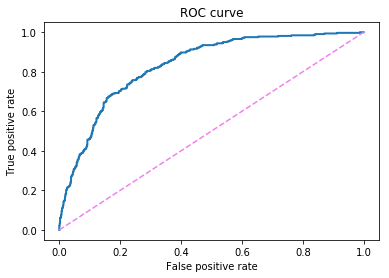

In [470]:
(out1, out2) = make_model_prediction_coefs(cols = cols, cf = "coefficients")
out2

### KNN

In [372]:
knn = KNeighborsClassifier(algorithm = 'auto', leaf_size=30,
           metric_params = None, n_jobs=-1, n_neighbors = 6, p = 2,
           weights='uniform')

In [373]:
knn.fit(train_X,train_Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
           weights='uniform')

In [392]:
predictions_knn   = knn.predict(val_X)
probabilities_knn = knn.predict_proba(val_X)

In [395]:
print("\n Classification report : \n",classification_report(val_Y ,predictions_knn))
print("Accuracy Score   : ",accuracy_score(val_Y ,predictions_knn))


 Classification report : 
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       803
           1       0.59      0.42      0.49       322

   micro avg       0.75      0.75      0.75      1125
   macro avg       0.69      0.65      0.66      1125
weighted avg       0.73      0.75      0.74      1125

Accuracy Score   :  0.7502222222222222


Area under curve :  0.6520269486320707 



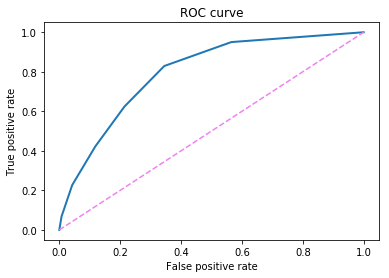

In [401]:
plot_roc(val_Y = val_Y, preds = predictions_knn, probs = probabilities_knn)

### Random Forest

In [ ]:
forest = RandomForestClassifier()

In [425]:
#     plot_roc(test_y, preds = predictions, probs = probabilities)



#     fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
#                             subplot_titles=('Receiver operating characteristic',
#                                             'Feature Importances'))


bars = go.Bar(x = [2,4,6,7,8,7], y = [1,2,1,3,2,1],
        name = "coefficients",
        marker = dict(color = 'rgb(158,60,60)',
                      colorscale = "Viridis",
                      line = dict(width = .6, color = "black")))

#     roc_line = go.Scatter(x = fpr,y = tpr,
#                         name = "Roc : " + str(model_roc_auc),
#                         line = dict(color = ('rgb(22, 96, 167)'),width = 2))

#     roc_stand = go.Scatter(x = [0,1],y=[0,1],
#                         line = dict(color = ('rgb(205, 12, 24)'),width = 2,
#                         dash = 'dot'))

#     matrix = go.Heatmap(z = conf_matrix ,
#                         x = ["Non churn","Churn"],
#                         y = ["Non churn","Churn"],
#                         showscale  = False, colorscale = "Viridis",
#                         name = "matrix")




#     fig.append_trace(bars,1,1)
#     fig.append_trace(roc_line,2,1)
#     fig.append_trace(roc_stand,1,2)
#fig.append_trace(matrix,2,2)

# bars['layout'].update(showlegend = False, title="Model performance" ,
#              autosize = False,height = 900,width = 800,
#              plot_bgcolor = 'rgba(220,220,220, 0.9)',
#              paper_bgcolor = 'rgba(220,220,220, 0.9)',
#              margin = dict(b = 195))

#     fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
#     fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
#     fig["layout"]["xaxis1"].update(dict(showgrid = True,tickfont = dict(size = 10),
#                                         tickangle = 90))

py.iplot([bars])

In [424]:
data = [go.Bar(
            x=[2,4,6,7,8,7], y = [1,2,1,3,2,1]
    )]

py.iplot(data, filename='basic-bar')